<a href="https://colab.research.google.com/github/prajotmo/next-word-prediction-using-BI--LSTM/blob/main/fakenewsusingdidtilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Assuming you have two files: fake.csv and true.csv
fake = pd.read_csv("/content/drive/MyDrive/Fake.csv")
true = pd.read_csv("/content/drive/MyDrive/True.csv")

fake['label'] = 0
true['label'] = 1

News = pd.concat([fake, true], axis=0).sample(frac=1).reset_index(drop=True)
News = News[['text', 'label']]


In [4]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
import re
import string
import spacy

# Load English NLP model
nlp = spacy.load("en_core_web_sm")


In [6]:
def basic_cleaning(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"@\w+|\#\w+", "", text)  # Remove mentions/hashtags
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text


In [7]:
# Apply to your DataFrame (assuming your column is 'text')
News["basic_clean_text"] = News["text"].apply(basic_cleaning)

# Show original and cleaned text side-by-side
News[["text", "basic_clean_text"]].head()

,text,basic_clean_text
0,MADRID (Reuters) - Catalonian leaders on Frida...,madrid reuters catalonian leaders on friday ap...
1,WASHINGTON (Reuters) - Half of America’s likel...,washington reuters half of america’s likely vo...
2,HOUSTON (Reuters) - Buckeye Partners LP s Yabu...,houston reuters buckeye partners lp s yabucoa ...
3,SAN FRANCISCO (Reuters) - A California federal...,san francisco reuters a california federal jud...
4,Monica Crowley offers some of the most brillia...,monica crowley offers some of the most brillia...


In [9]:
def clean_and_lemmatize(text):
    # Step 1: Basic Cleaning
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"@\w+|\#\w+", "", text)  # Remove mentions/hashtags
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces

    # Step 2: Lemmatize and remove stopwords using spaCy
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]

    return " ".join(tokens)


In [10]:
News["lemmatized_text"] = News["text"].apply(clean_and_lemmatize)


In [11]:
News[["text", "basic_clean_text", "lemmatized_text"]].head()


,text,basic_clean_text,lemmatized_text
0,MADRID (Reuters) - Catalonian leaders on Frida...,madrid reuters catalonian leaders on friday ap...,madrid reuters catalonian leader friday appeal...
1,WASHINGTON (Reuters) - Half of America’s likel...,washington reuters half of america’s likely vo...,washington reuters half america likely voter r...
2,HOUSTON (Reuters) - Buckeye Partners LP s Yabu...,houston reuters buckeye partners lp s yabucoa ...,houston reuters buckeye partner lp s yabucoa o...
3,SAN FRANCISCO (Reuters) - A California federal...,san francisco reuters a california federal jud...,san francisco reuters california federal judge...
4,Monica Crowley offers some of the most brillia...,monica crowley offers some of the most brillia...,monica crowley offer brilliant political analy...


In [12]:

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    News["lemmatized_text"].tolist(), News["label"].tolist(), test_size=0.2, random_state=42
)


In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [14]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})


In [15]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2  # Change num_labels if more classes
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
!pip install --upgrade transformers


In [24]:
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    fp16=True,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics # Added compute_metrics
)

In [25]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.011954,0.998664,0.997888,0.999295,0.998591
2,0.000000,0.009120,0.998886,0.998356,0.999295,0.998825
3,0.000000,0.006780,0.999220,0.998826,0.999530,0.999178


TrainOutput(global_step=13470, training_loss=0.005933358732853483, metrics={'train_runtime': 4380.0836, 'train_samples_per_second': 24.601, 'train_steps_per_second': 3.075, 'total_flos': 1.4273892074778624e+16, 'train_loss': 0.005933358732853483, 'epoch': 3.0})

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names=["Fake", "Real"]):
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()


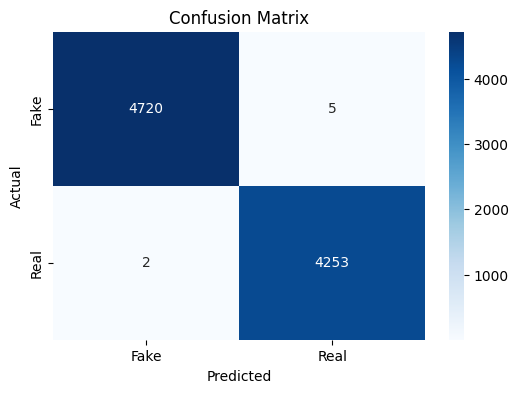

In [28]:
from sklearn.metrics import confusion_matrix

# Get predictions on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Calculate and plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm)